# ADT

In [360]:
import os
import sys

import pickle
import numpy as np
import glob

import warnings # ignore tensorflow warinings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from keras import backend as K
import soundfile as psf

sys.path.append('models')
from large_vocab_adt_dafx2018.transcribe import transcribe, PERC_VOICE_SET
import large_vocab_adt_dafx2018.model as model

# pip install pyrsistent==0.16.1

## Download Groove MIDI Dataset

In [361]:
# DOWNLOAD GROOVE MIDI DATASET
import requests, zipfile, io

groove_path = 'groove/'

# if dir exists and is empty, remove
if os.path.exists(groove_path) and os.listdir(groove_path)==0:
    os.removedirs(groove_path)

# if dir does not exist, download dataset
if not os.path.exists(groove_path):
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("./")

## Compute ADT to 8 voices

In [394]:
models_path = 'models/large_vocab_adt_dafx2018/trained_models/'

# load model
model_definition_path = os.path.join(models_path,'303_s0_def.json')
model_weights_path = os.path.join(models_path,'303_s0_weights.h5')
model_configuration_id = 303
sample_audio_files = dict([(v, os.path.join('models/audio/', '{}.wav'.format(v))) for v in PERC_VOICE_SET])

# audio file
input_audio_file = 'groove/drummer1/session1/1_funk_80_beat_4-4.wav'

# compute model's onsets >> outputs 14 voices
output = transcribe(model_definition_path,
                    model_weights_path,
                    input_audio_file,
                    model_configuration_id,
                    sample_audio_files,
                    peak_params=None,
                    output_sample_rate=44100)

# save into out_14v
out_14v = output['14v']['onset_activations']

Single output


Since the model outputs 14 voices, we need to reduce them to the 8 ones present in the magenta dataset. In the magenta dataset there's actually 9 but one has no correspondence with the ones that this model outputs, so I removed it

In [395]:
# reduce 14 voices to the 8 present in the magenta dataset

length_in_samples = model_14v.shape[0]
out_8v = np.zeros([length_in_samples,8])

reduced_mapping = {
    0: [0],     # kick
    1: [1,2],   # snare + snare rim 
    2: [3],     # crash
    3: [4,12],  # ride + bell
    4: [5],     # open hh
    5: [6],     # closed hh
    6: [7,8],   # low+mid tom
    7: [9]      # high tom
}


eps = 0 # threshold ?

for t in range(length_in_samples):
    t_roll = model_14v[t,:]
    t_roll[t_roll<eps] = 0
    for i in reduced_mapping.keys():
        out_8v[t,i] = np.max(t_roll[reduced_mapping[i]])

### Get model onsets function

In [384]:
def get_model_onsets(input_audio_file, model=''):
    
    models_path = 'models/large_vocab_adt_dafx2018/trained_models/'

    # load model
    model_definition_path = os.path.join(models_path,'303_s0_def.json')
    model_weights_path = os.path.join(models_path,'303_s0_weights.h5')
    model_configuration_id = 303
    sample_audio_files = dict([(v, os.path.join('models/audio/', '{}.wav'.format(v))) for v in PERC_VOICE_SET])


    # compute model's onsets >> outputs 14 voices
    output = transcribe(model_definition_path,
                    model_weights_path,
                    input_audio_file,
                    model_configuration_id,
                    sample_audio_files,
                    peak_params=None,
                    output_sample_rate=44100)

    # save into out_14v
    out_14v = output['14v']['onset_activations']
    
    # reduce 14 voices to the 8 present in the magenta dataset
    length_in_samples = model_14v.shape[0]
    out_8v = np.zeros([length_in_samples,8])

    reduced_mapping = {
    0: [0],     # kick
    1: [1,2],   # snare + snare rim 
    2: [3],     # crash
    3: [4,12],  # ride + bell
    4: [5],     # open hh
    5: [6],     # closed hh
    6: [7,8],   # low+mid tom
    7: [9]      # high tom
    }


    eps = 0 # threshold ?

    for t in range(length_in_samples):
        t_roll = model_14v[t,:]
        t_roll[t_roll<eps] = 0
        for i in reduced_mapping.keys():
            out_8v[t,i] = np.max(t_roll[reduced_mapping[i]])
    
    return out_8v

## Extract onsets from midi file

In [385]:
import pretty_midi

# same as audio file but changing .wav to .mid
input_midi_file = input_audio_file.split('.')[-2] + '.mid'
midi_data = pretty_midi.PrettyMIDI(input_midi_file)

# extract onsets from midi file with midi_data.get_onsets()
onsets = midi_data.get_onsets()

In [386]:
# get pretty_midi Notes objects in a list
drums_notes = midi_data.instruments[0].notes[:]

drums_onsets = []
drums_instrument = []

for note in drums_notes:
    drums_onsets.append(note.start)    # onsets list
    drums_instrument.append(note.pitch)   # instrument  

drums_onsets = np.round(drums_onsets,2) # in seconds
drums_onsets = np.round(drums_onsets/0.01,0) # in samples


In [387]:
# map to 8 voices

magenta_mapping = { # [key, [pitches]]
    "kick":[0,[36]],
    "snare":[1,[38,40,37]],
    "crash":[2,[49,55,57,52]],
    "ride":[3,[51,59,53]],
    "open_hh":[4,[46,26]],
    "closed_hh":[5,[42,22,44]],
    "low_mid_tom":[6,[45,47]],
    "high_tom":[7,[48,50]]
}

magenta_transcription = np.zeros([length_in_samples,8])

for onset,inst in zip(drums_onsets,drums_instrument):
    onset = int(onset)
    
    # map pretty_midi pitch to magenta pitch value
    for magenta_inst in magenta_mapping.keys():
        
        if inst in magenta_mapping[magenta_inst][1]:
            magenta_transcription[onset][magenta_mapping[magenta_inst][0]] = 1

### Get magenta onsets function

In [388]:
# write in a function

def get_magenta_onsets(input_midi_file):
    # read with prettyMIDI
    midi_data = pretty_midi.PrettyMIDI(input_midi_file)

    # extract onsets from midi file with midi_data.get_onsets()
    onsets = midi_data.get_onsets()
    
    # get pretty_midi Notes objects in a list
    drums_notes = midi_data.instruments[0].notes[:]
    
    # initiate drum_onsets and instruments array
    drums_onsets = []
    drums_instrument = []
    
    # fill with info from prettymidi notes objects
    for note in drums_notes:
        drums_onsets.append(note.start)    # onsets list
        drums_instrument.append(note.pitch)   # instrument  
    
    # transform onsets to seconds
    drums_onsets = np.round(drums_onsets,2) # in seconds
    drums_onsets = np.round(drums_onsets/0.01,0) # in samples

    
    # magenta pitch to model pitch (map to 8 voices)
    magenta_mapping = { # [key, [pitches]]
        "kick":[0,[36]],
        "snare":[1,[38,40,37]],
        "crash":[2,[49,55,57,52]],
        "ride":[3,[51,59,53]],
        "open_hh":[4,[46,26]],
        "closed_hh":[5,[42,22,44]],
        "low_mid_tom":[6,[45,47]],
        "high_tom":[7,[48,50]]
        }
    
    # initiate magenta_transcription matrix with zeros
    magenta_transcription = np.zeros([length_in_samples,8])

    # fill magenta_transcription with onsets info
    for onset,inst in zip(drums_onsets,drums_instrument):
        onset = int(onset)
    
        # map pretty_midi pitch to magenta pitch value
        for magenta_inst in magenta_mapping.keys():
        
            if inst in magenta_mapping[magenta_inst][1]:
                magenta_transcription[onset][magenta_mapping[magenta_inst][0]] = 1
    
    return magenta_transcription
    

# Plot

In [389]:
import matplotlib.pyplot as plt
import librosa.display

%matplotlib inline

def plot_activations(X, start_s, stop_s, sample_interval, sr=44100, size=(15,5)):
    sample_interval = int(round(sample_interval * sr)) / float(sr)
    hop_length = int(sample_interval * sr)
    start_idx = int(start_s / sample_interval)
    stop_idx = int(stop_s / sample_interval)
    plt.figure(figsize=size)
    
    print(np.where(X[start_idx:stop_idx,0]>0)[0]*0.01)
    
    librosa.display.specshow(X[start_idx:stop_idx,:].T, 
                             sr=sr, 
                             hop_length=hop_length,
                             x_axis='time')
        
    labels = ['0 : Kick Drum', # 0
                  '1 : Snare', # 1 Snare + Snare Rim
                  '2 : Crash', # 2
                  '3 : Ride', # 3 Ride + Bell
                  '4 : Open Hi-Hat', # 4
                  '5 : Closed Hi-Hat', # 5
                  '6 : Low-Mid Tom', # 6 Low + Mid
                  '7 : High Tom'] # 7
     
    plt.yticks(np.arange(X.shape[1]) + 0.5, labels)
    
    # TODO change range in x

In [397]:
input_audio_file = 'groove/drummer1/session1/1_funk_80_beat_4-4.wav'
input_midi_file = input_audio_file.split('.')[-2] + '.mid'



# add threshold
out_8v_thres = out_8v
out_8v_thres[out_8v < 0.05] = 0
out_8v_thres[out_8v_thres>0] = 1

# Plot activations

[2.97 2.98 3.93 4.78 5.35 5.36 5.37 6.32 6.33 6.93 7.8  8.38 8.39 9.31
 9.91]
[3.   3.37 3.96 4.81 5.38 6.36 6.96 7.83 8.42 9.35 9.95]


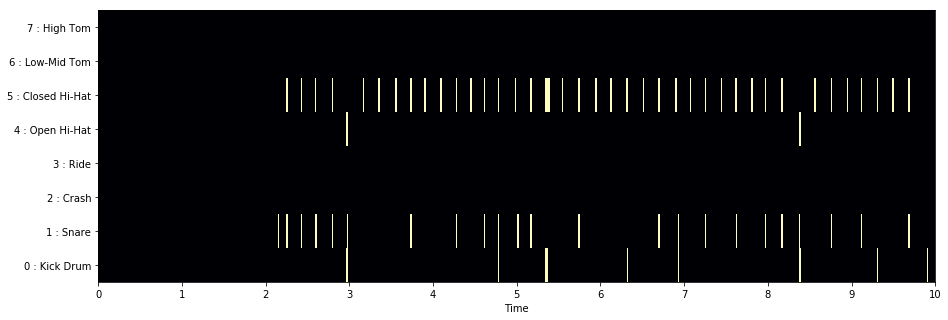

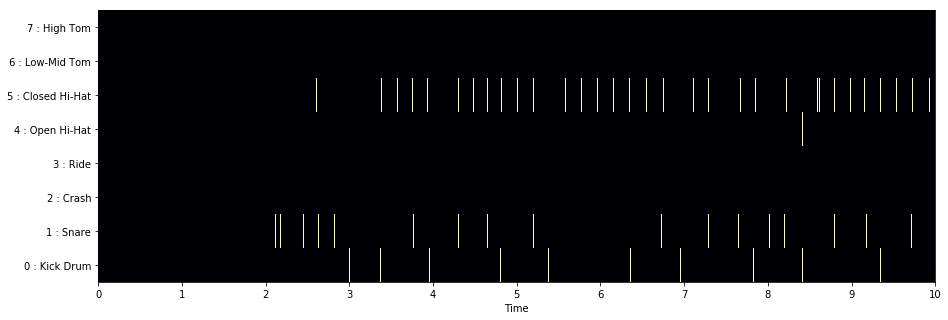

In [398]:
plot_activations(out_8v_thres, 0, 10, 0.01)
plot_activations(magenta_transcription, 0, 10, 0.01)

# Evaluation
para hacer la evaluación hay q pasar un array de los onsets en segundos

In [406]:
import mir_eval

onsets_eval_magenta = np.arange(length_in_samples)*magenta_transcription[:,5]*0.01 
onsets_eval_magenta = np.sort(onsets_eval_magenta[onsets_eval_magenta!=0])

onsets_eval_model = np.arange(length_in_samples)*out_8v_thres[:,5]*0.01
onsets_eval_model = np.sort(onsets_eval_model[onsets_eval_model!=0])


print(onsets_eval_magenta[0:5])
print(np.round(onsets_eval_model[0:5],2))

# mir_eval: 
# Onsets should be provided in the form of a 1-dimensional array of onset 
# times in seconds in increasing order.
# default window is 0.05 seconds !! CHOICE OF WINDOW IS CRUCIAL
mir_eval.onset.validate(onsets_eval_magenta,onsets_eval_model)
scores = mir_eval.onset.evaluate(onsets_eval_magenta,onsets_eval_model, window=0.1)
print(scores)

[2.61 3.2  3.39 3.58 3.76]
[2.09 2.25 2.26 2.43 2.6 ]
OrderedDict([('F-measure', 0.7040816326530612), ('Precision', 0.550531914893617), ('Recall', 0.9764150943396226)])


## Batch evaluation

In [351]:
import pandas as pd

# load info from dataset
magenta_ds = pd.read_csv('groove/info.csv')

# remove rows without wav file
magenta_ds = magenta_ds.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False) 

magenta_ds.head()

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test


In [359]:
# indexes correspond to the same performance

audio_files_list = magenta_ds['audio_filename']
midi_files_list = magenta_ds['midi_filename']
total_performances = len(audio_files_list)

for performance_idx in range(total_performances):
    
    # prod
    if performance_idx>0:
        break
    
    percentage = (performance_idx+1) * 100  / total_performances
    print(str(percentage) + '%')
    
    audio_file = os.path.join(groove_path, audio_files_list[performance_idx])
    midi_file = os.path.join(groove_path,midi_files_list[performance_idx])
    
    # get magenta onsets 
    magenta_onsets = get_magenta_onsets(midi_file)
    # get model onsets
    model_onsets = get_model_onsets(audio_file)
    
    

0%
Single output


## Helpers

In [224]:
# HELPERS 
# Model 303 is the Small, Multi-task model trained on real + synth, with classes weighted by entropy
#
# Other models:
# MT-S-R (289)
# MT-S-S (290)
# MT-S-R+S (291)
# MT-L-R (292)
# MT-L-S (293)
# MT-L-R+S (294)
# 14VST-S-R+S (295)
# 3VST-S-R+S (301)
# BTST-S-R+S (302)
# 14VST-S-R+S-Eweight (303)